In [1]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.spatial import cKDTree
import open3d as o3d
from collections import defaultdict

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pc_seg.pc_label_map import color_map_dict

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Invert the colormap to get RGB → label index
rgb_to_label = {tuple(v[0]): k for k, v in color_map_dict.items()}
label_to_name = {k: v[1] for k, v in color_map_dict.items()}

def get_label_from_color(color_array):
    """Match color to closest known semantic color label."""
    labels = []
    for c in color_array:
        # Round to 3 decimals to avoid float precision mismatch
        key = tuple(np.round(c, 3))
        label = rgb_to_label.get(key, -1)  # -1 if unmatched
        labels.append(label)
    return np.array(labels)

In [3]:
# Load GT and predicted point clouds
gt_pcd = o3d.io.read_point_cloud("../docs/SmartLab_2024_E57_Single_5mm_SEG_colors.ply")   # full resolution
pred_pcd = o3d.io.read_point_cloud("../docs/Smartlab_s3dis_label_pointnet2_x6_0.03_20250422.ply")   # downsampled

In [11]:
o3d.visualization.draw_geometries([gt_pcd], point_show_normal=False)

In [12]:
o3d.visualization.draw_geometries([pred_pcd], point_show_normal=False)

In [4]:
def print_label_counts(label_array, name="Point Cloud"):
    print(f"\n📦 Label counts for {name}:")
    unique_labels, counts = np.unique(label_array, return_counts=True)
    for label, count in zip(unique_labels, counts):
        class_name = label_to_name.get(label, f"Class {label}")
        print(f"  {label:2d} ({class_name:10s}): {count} points")

In [5]:
# Move the point cloud to its min(x,y,z) corner
 
def move_to_corner(points):    
    # Find the minimum x, y, z
    min_xyz = points.min(axis=0)
    # Translate the point cloud so that the min corner becomes the origin
    moved_points = points - min_xyz
    
    return moved_points

moved_points = move_to_corner(np.array(gt_pcd.points))
gt_pcd.points = o3d.utility.Vector3dVector(moved_points)

In [24]:
# Extract point coordinates and colors
gt_points = np.asarray(gt_pcd.points)
gt_origin_colors = np.asarray(gt_pcd.colors)
gt_colors = np.round(gt_origin_colors, 1)

pred_points = np.asarray(pred_pcd.points)
pred_origin_colors = np.asarray(pred_pcd.colors)
pred_colors = np.round(pred_origin_colors, 1)

# Convert color to semantic labels
gt_labels = get_label_from_color(gt_colors)
pred_labels = get_label_from_color(pred_colors)

In [7]:
# Ground Truth
print_label_counts(gt_labels, name="Ground Truth")

# Prediction
print_label_counts(pred_labels, name="Prediction")


📦 Label counts for Ground Truth:
   0 (ceiling   ): 5701035 points
   1 (floor     ): 5167644 points
   2 (wall      ): 11348550 points
   4 (column    ): 173882 points
   5 (window    ): 549543 points
   6 (door      ): 1451390 points
   7 (table     ): 243330 points
   8 (chair     ): 99590 points
   9 (sofa      ): 190263 points
  11 (board     ): 488769 points
  12 (clutter   ): 10552776 points

📦 Label counts for Prediction:
   0 (ceiling   ): 130218 points
   1 (floor     ): 120958 points
   2 (wall      ): 277981 points
   4 (column    ): 5052 points
   5 (window    ): 208 points
   6 (door      ): 20088 points
   7 (table     ): 114 points
   8 (chair     ): 7 points
  10 (bookcase  ): 63449 points
  11 (board     ): 14 points
  12 (clutter   ): 248811 points


In [9]:
# Filter out unmatched labels (e.g. -1)
valid_mask = (gt_labels != -1)
gt_points = gt_points[valid_mask]
gt_labels = gt_labels[valid_mask]

# KDTree nearest neighbor matching
tree = cKDTree(gt_points)
_, indices = tree.query(pred_points, k=1)
matched_pred_labels = gt_labels[indices]

# Overall accuracy
overall_accuracy = accuracy_score(pred_labels, matched_pred_labels)
print(f"\n✅ Overall Accuracy: {overall_accuracy:.3f}")

# Per-class accuracy
print("\n📋 Per-Class Accuracy:")
class_counts = defaultdict(int)
correct_counts = defaultdict(int)

for true, pred in zip(pred_labels, matched_pred_labels):
    class_counts[true] += 1
    if true == pred:
        correct_counts[true] += 1

for label in sorted(class_counts.keys()):
    correct = correct_counts[label]
    total = class_counts[label]
    acc = correct / total if total > 0 else 0.0
    class_name = label_to_name.get(label, f"Class {label}")
    print(f"  {label:2d} ({class_name:10s}): {acc:.3f} ({correct}/{total})")





✅ Overall Accuracy: 0.662

📋 Per-Class Accuracy:
   0 (ceiling   ): 0.937 (121952/130218)
   1 (floor     ): 0.960 (116098/120958)
   2 (wall      ): 0.575 (159789/277981)
   4 (column    ): 0.000 (0/5052)
   5 (window    ): 0.404 (84/208)
   6 (door      ): 0.176 (3526/20088)
   7 (table     ): 0.368 (42/114)
   8 (chair     ): 0.000 (0/7)
  10 (bookcase  ): 0.000 (0/63449)
  11 (board     ): 0.000 (0/14)
  12 (clutter   ): 0.692 (172196/248811)


In [10]:
# Classification report
# Ensure all labels used in GT or prediction are covered
all_labels = sorted(set(pred_labels) | set(matched_pred_labels))

print(classification_report(
    pred_labels,
    matched_pred_labels,
    labels=all_labels,
    target_names=[label_to_name.get(i, f"Class {i}") for i in all_labels]
))

C:\Users\yanpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yanpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     ceiling       0.84      0.94      0.89    130218
       floor       0.95      0.96      0.96    120958
        wall       0.73      0.57      0.64    277981
      column       0.00      0.00      0.00      5052
      window       0.01      0.40      0.01       208
        door       0.11      0.18      0.13     20088
       table       0.01      0.37      0.01       114
       chair       0.00      0.00      0.00         7
        sofa       0.00      0.00      0.00         0
    bookcase       0.00      0.00      0.00     63449
       board       0.00      0.00      0.00        14
     clutter       0.57      0.69      0.62    248811

    accuracy                           0.66    866900
   macro avg       0.27      0.34      0.27    866900
weighted avg       0.66      0.66      0.66    866900



C:\Users\yanpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yanpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yanpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:15

In [41]:
def accuracy_per_class(gt_points,gt_labels,pred_file):
    results = []
    # Extract point coordinates and colors
    #gt_points = np.asarray(gt_pcd.points)
    #gt_origin_colors = np.asarray(gt_pcd.colors)
    #gt_colors = np.round(gt_origin_colors, 1)

    pred_pcd = o3d.io.read_point_cloud(pred_file[1])

    pred_points = np.asarray(pred_pcd.points)
    pred_origin_colors = np.asarray(pred_pcd.colors)
    pred_colors = np.round(pred_origin_colors, 1)

    # Convert color to semantic labels
    #gt_labels = get_label_from_color(gt_colors)
    pred_labels = get_label_from_color(pred_colors)
    
    # Filter out unmatched labels (e.g. -1)
    valid_mask = (gt_labels != -1)
    gt_points = gt_points[valid_mask]
    gt_labels = gt_labels[valid_mask]

    # KDTree nearest neighbor matching
    tree = cKDTree(gt_points)
    _, indices = tree.query(pred_points, k=1)
    matched_pred_labels = gt_labels[indices]

    # Overall accuracy
    overall_accuracy = accuracy_score(pred_labels, matched_pred_labels)
    #print(f"\n✅ Overall Accuracy: {overall_accuracy:.3f}")
    results.append({
            "Model": pred_file[0],
            "Class": "Overall",
            "Accuracy": overall_accuracy
        })

    # Per-class accuracy
    #print("\n📋 Per-Class Accuracy:")
    class_counts = defaultdict(int)
    correct_counts = defaultdict(int)

    for true, pred in zip(pred_labels, matched_pred_labels):
        class_counts[true] += 1
        if true == pred:
            correct_counts[true] += 1

    for label in sorted(class_counts.keys()):
        correct = correct_counts[label]
        total = class_counts[label]
        acc = correct / total if total > 0 else 0.0
        class_name = label_to_name.get(label, f"Class {label}")
        #print(f"  {label:2d} ({class_name:10s}): {acc:.3f} ({correct}/{total})")

        results.append({
            "Model": pred_file[0],
            "Class": class_name,
            "Accuracy": acc
        })

    return results

In [38]:
prediction_files = [
    ("S3DIS_Colors","../docs/Smartlab_s3dis_transform_label_pointnet2_x6_0.03_20250423.ply"),
    ("S3DIS_No_Colors","../docs/Smartlab_s3dis_transform_label_pointnet2_x3_0.03_20250423.ply"),
    ("Simulated","../docs/Smartlab_simulated_pretransform_label_pointnet2_x3_0.03_20250423.ply"),
    ("Simulated_finetuned","../docs/Smartlab_aalto_pcd_finetuned_label_pointnet2_x3_0.03_20250416.ply"),
    ("LoRA_finetuned","../docs/Smartlab_pcd_lora_label_pointnet2_x3_0.03_20250426.ply")
]

In [42]:
results = []
for file in prediction_files:
    results += accuracy_per_class(gt_points,gt_labels,file)


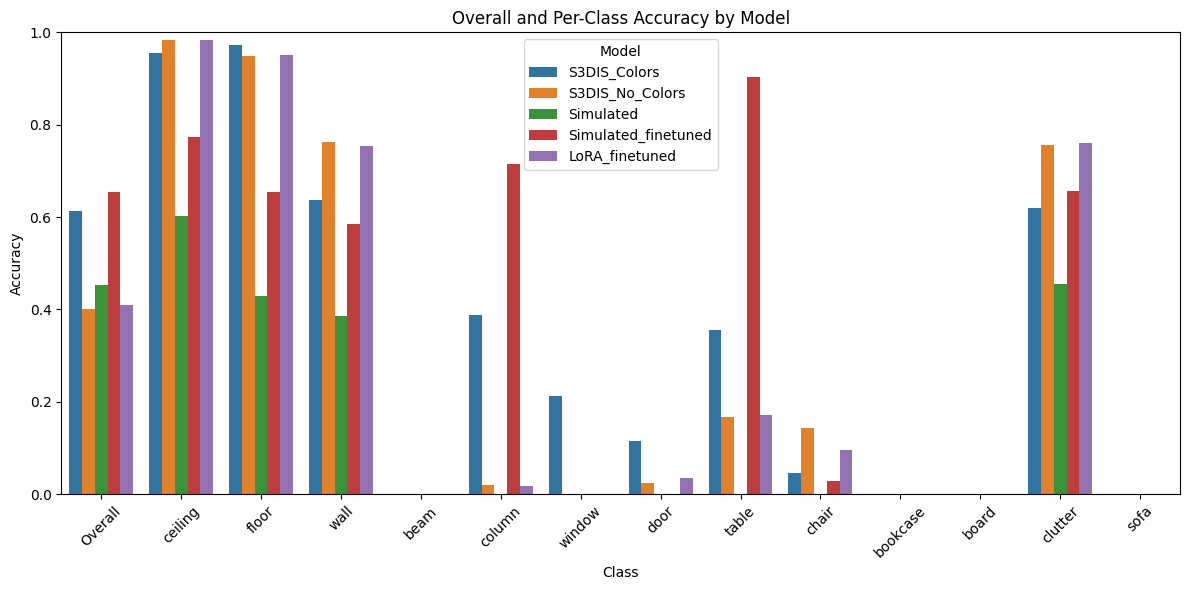

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Class", y="Accuracy", hue="Model")
plt.title("Overall and Per-Class Accuracy by Model")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()


In [44]:
df.head()

,Model,Class,Accuracy
0,S3DIS_Colors,Overall,0.613871
1,S3DIS_Colors,ceiling,0.954771
2,S3DIS_Colors,floor,0.971747
3,S3DIS_Colors,wall,0.636541
4,S3DIS_Colors,beam,0.000000


In [8]:
# Compute the centroid
gt_centroid = gt_points.mean(axis=0)
pred_centroid = pred_points.mean(axis=0)

print(gt_centroid)
print(pred_centroid)

[5.25884302 5.6081679  1.74653798]
[5.20587027 5.64833263 1.76726065]


In [15]:
gt_min_xyz = gt_points.min(axis=0)
pred_min_xyz = pred_points.min(axis=0)

print(gt_min_xyz)
print(pred_min_xyz)

[-1.03750002 -4.06758022 -1.56200004]
[0.         0.00400019 0.00703452]
